Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s]



 Training Decision Tree...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


🔹 Decision Tree Default Accuracy: 0.5471
Decision Tree Best Parameters: {'max_depth': None}
Decision Tree Tuned Accuracy: 0.5412

 Training Random Forest...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


🔹 Random Forest Default Accuracy: 0.8176
Random Forest Best Parameters: {'n_estimators': 100}
Random Forest Tuned Accuracy: 0.8353

 Training SVM...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


🔹 SVM Default Accuracy: 0.9059
SVM Best Parameters: {'C': 0.1}
SVM Tuned Accuracy: 0.9059

 Training AdaBoost...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


🔹 AdaBoost Default Accuracy: 0.3765
AdaBoost Best Parameters: {'n_estimators': 50}
AdaBoost Tuned Accuracy: 0.3765

 Training Gradient Boosting...
🔹 Gradient Boosting Default Accuracy: 0.6941

 Training XGBoost...


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:23:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:23:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:23:57] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.


🔹 XGBoost Default Accuracy: 0.7824
XGBoost Best Parameters: {'n_estimators': 50, 'learning_rate': 0.1}
XGBoost Tuned Accuracy: 0.7824

 Training CatBoost...
🔹 CatBoost Default Accuracy: 0.7824

 Training Naive Bayes...
🔹 Naive Bayes Default Accuracy: 0.8235

 Training MLP...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 2 is smaller than n_iter=5. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


🔹 MLP Default Accuracy: 0.9000
MLP Best Parameters: {'hidden_layer_sizes': (100,)}
MLP Tuned Accuracy: 0.8941


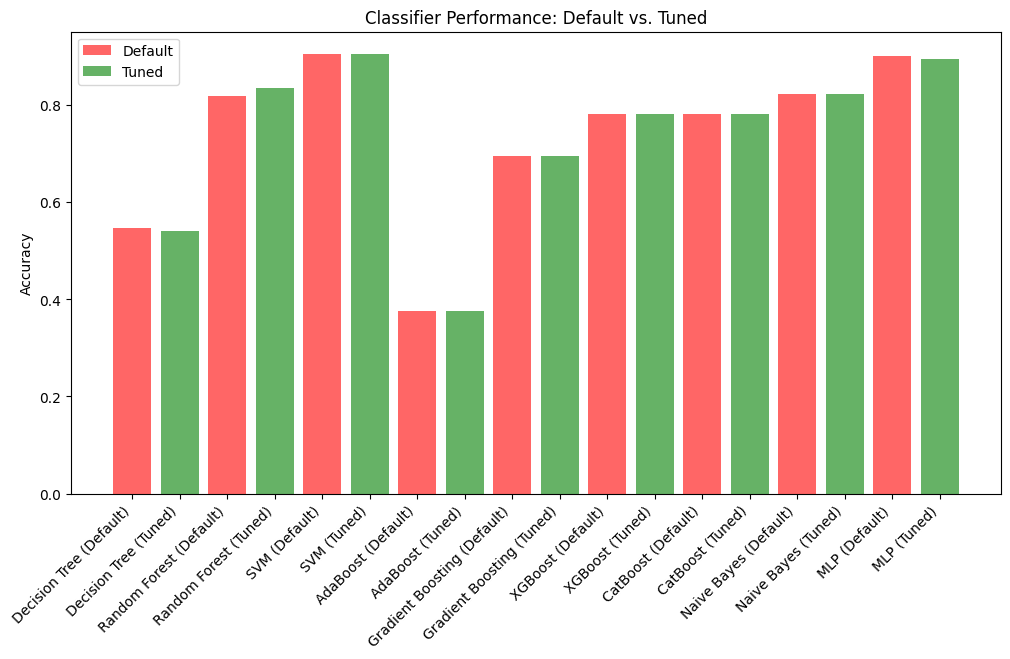


 Best Hyperparameters for Each Tuned Model:
Decision Tree: {'max_depth': None}
Random Forest: {'n_estimators': 100}
SVM: {'C': 0.1}
AdaBoost: {'n_estimators': 50}
XGBoost: {'n_estimators': 50, 'learning_rate': 0.1}
MLP: {'hidden_layer_sizes': (100,)}
Performing Agglomerative Hierarchical Clustering...


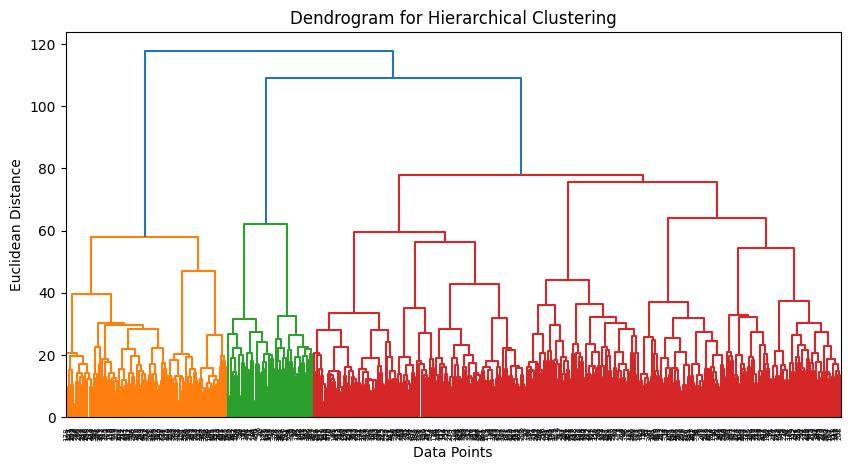

Performing DBSCAN Clustering...


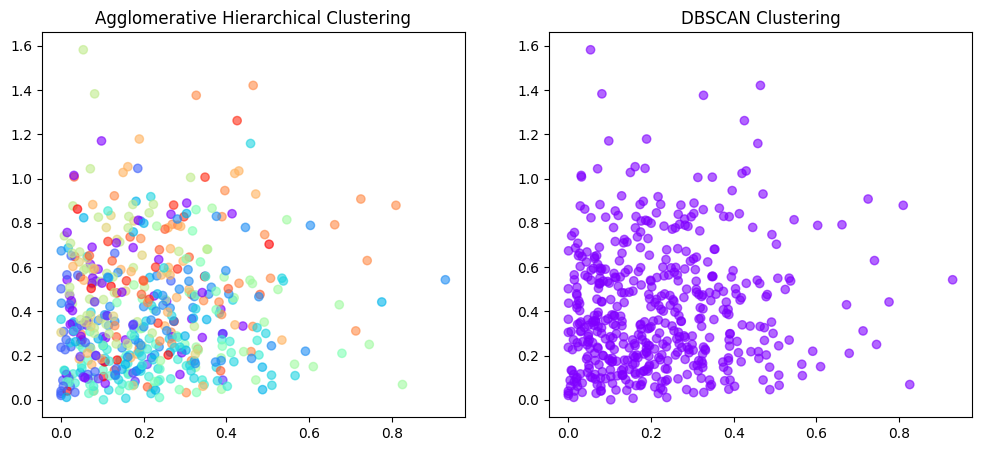

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import torch
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.cluster import AgglomerativeClustering, DBSCAN
import scipy.cluster.hierarchy as sch

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load dataset paths
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/flowers1"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "validation")

# Image Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Pretrained ResNet-50 Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove FC layer
model.eval().to(device)

# Custom Dataset Class
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths, self.labels = [], []
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_file in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_file)
                if os.path.isfile(img_path):
                    self.image_paths.append(img_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        return self.transform(image), self.labels[idx]

# Feature Extraction
def extract_features(dataset, sample_size=None):
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    features, labels = [], []
    with torch.no_grad():
        for images, lbls in loader:
            images = images.to(device)
            output = model(images).view(images.size(0), -1)
            features.append(output.cpu().numpy())
            labels.append(lbls.numpy())

    X = np.vstack(features)
    y = np.hstack(labels)

    # Use only a subset for faster training
    if sample_size and sample_size < len(y):
        idx = np.random.choice(len(y), sample_size, replace=False)
        X, y = X[idx], y[idx]

    return X, y

# Load Datasets with a subset for faster training
X_train, y_train = extract_features(ImageDataset(TRAIN_DIR, transform), sample_size=500)
X_test, y_test = extract_features(ImageDataset(VAL_DIR, transform), sample_size=200)

# Define Classifiers
classifiers = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=50, n_jobs=-1),
    "SVM": SVC(C=1.0, kernel="linear"),
    "AdaBoost": AdaBoostClassifier(n_estimators=50),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=50, max_depth=3, warm_start=True),
    "XGBoost": XGBClassifier(n_estimators=50, max_depth=3, tree_method='gpu_hist' if torch.cuda.is_available() else 'auto'),
    "CatBoost": CatBoostClassifier(iterations=50, depth=3, verbose=0, task_type="GPU" if torch.cuda.is_available() else "CPU"),
    "Naive Bayes": GaussianNB(),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=200)
}

# Hyperparameter Tuning with RandomizedSearchCV (Reduced Iterations)
param_grid = {
    "Decision Tree": {"max_depth": [10, 20, None]},
    "Random Forest": {"n_estimators": [10, 50, 100]},
    "SVM": {"C": [0.1, 1, 10]},
    "AdaBoost": {"n_estimators": [10, 50]},
    "XGBoost": {"n_estimators": [10, 50], "learning_rate": [0.01, 0.1]},
    "MLP": {"hidden_layer_sizes": [(50,), (100,)]}
}

# Model Training and Hyperparameter Tuning
results = {}  # Store results for default and tuned models
best_params = {}  # Store best hyperparameters

for name, clf in classifiers.items():
    print(f"\n Training {name}...")

    # Train Default Model
    clf.fit(X_train, y_train)
    y_pred_default = clf.predict(X_test)
    default_acc = accuracy_score(y_test, y_pred_default)

    # Perform Hyperparameter Tuning if applicable
    if name in param_grid:
        search = RandomizedSearchCV(clf, param_grid[name], n_iter=5, cv=3, n_jobs=-1, random_state=42)
        search.fit(X_train, y_train)
        best_clf = search.best_estimator_
        best_params[name] = search.best_params_  # Store best parameters
    else:
        best_clf = clf  # If no tuning is required, use default

    # Train Best Tuned Model
    y_pred_tuned = best_clf.predict(X_test)
    tuned_acc = accuracy_score(y_test, y_pred_tuned)

    # Store results
    results[name] = {"Default": default_acc, "Tuned": tuned_acc}

    # Display Results
    print(f"🔹 {name} Default Accuracy: {default_acc:.4f}")
    if name in param_grid:
        print(f"{name} Best Parameters: {search.best_params_}")
        print(f"{name} Tuned Accuracy: {tuned_acc:.4f}")

# Plot Results
plt.figure(figsize=(12, 6))
for model, acc_dict in results.items():
    plt.bar(model + " (Default)", acc_dict["Default"], color="red", alpha=0.6)
    plt.bar(model + " (Tuned)", acc_dict["Tuned"], color="green", alpha=0.6)

plt.xticks(rotation=45, ha="right")
plt.ylabel("Accuracy")
plt.title("Classifier Performance: Default vs. Tuned")
plt.legend(["Default", "Tuned"])
plt.show()

# Display Best Parameters Found
print("\n Best Hyperparameters for Each Tuned Model:")
for model, params in best_params.items():
    print(f"{model}: {params}")

# --- Hierarchical Clustering ---
def hierarchical_clustering(X, n_clusters=5):
    print("Performing Agglomerative Hierarchical Clustering...")

    # Generate dendrogram
    plt.figure(figsize=(10, 5))
    dendrogram = sch.dendrogram(sch.linkage(X, method="ward"))
    plt.title("Dendrogram for Hierarchical Clustering")
    plt.xlabel("Data Points")
    plt.ylabel("Euclidean Distance")
    plt.show()

    # Apply Agglomerative Clustering
    hc = AgglomerativeClustering(n_clusters=n_clusters, metric="euclidean", linkage="ward")
    y_hc = hc.fit_predict(X)

    return y_hc

# --- DBSCAN Clustering ---
def dbscan_clustering(X, eps=0.5, min_samples=5):
    print("Performing DBSCAN Clustering...")
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean')
    y_db = dbscan.fit_predict(X)

    return y_db

# Apply Clustering on Feature Data
n_clusters = len(set(y_train))  # Assuming same number of clusters as classes

y_hierarchical = hierarchical_clustering(X_train, n_clusters)
y_dbscan = dbscan_clustering(X_train, eps=3, min_samples=5)

# Visualizing the clusters
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_hierarchical, cmap="rainbow", alpha=0.6)
plt.title("Agglomerative Hierarchical Clustering")

plt.subplot(1, 2, 2)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_dbscan, cmap="rainbow", alpha=0.6)
plt.title("DBSCAN Clustering")

plt.show()

In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 572.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 36.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
